In [1]:
from scipy.signal import butter, lfilter
import fastdyn_fic_dmf as dmf
import numpy as np
import matplotlib.pyplot as plt
# Fetch default parameters
import tracemalloc
from scipy.io import loadmat
from scipy.stats import zscore, pearsonr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mat73
# Helper functions
def compute_fcd(data, wsize, overlap, isubdiag):
    T, N = data.shape
    win_start = np.arange(0, T - wsize - 1, wsize - overlap)
    nwins = len(win_start)
    fcd = np.zeros((len(isubdiag[0]), nwins))
    #print(fcd.shape)
    #print(data.shape)
    #print((data[win_start[2]:win_start[2] + wsize + 1, :]).shape)
    for i in range(nwins):
        tmp = data[win_start[i]:win_start[i] + wsize + 1, :]
        cormat = np.corrcoef(tmp.T)
        fcd[:, i] = cormat[isubdiag[0],isubdiag[1]]
    return fcd


## Figure 1

In [5]:
coeffs = loadmat('./data/LinearFitCoefficients.mat')
C = loadmat('./data/SC_and_5ht2a_receptors.mat')['sc90']
C = 0.2*C/np.max(C)
coeffs = loadmat('./data/LinearFitCoefficients.mat')
a = coeffs['a'][0][0]
b = coeffs['b'][0][0]
a = coeffs['a'][0][0]
b = coeffs['b'][0][0]
LR = 1
DECAY = np.exp(a+np.log(LR)*b)

In [6]:
G_val = 2.1

In [7]:
params = dmf.default_params(C=C)
nb_steps = 50000
params['seed'] = 1
params['G'] = G_val
params['obj_rate'] = 3.44
LR = 10
DECAY = np.exp(a+np.log(LR)*b)
params['taoj'] = DECAY
params['lrj'] = LR
params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
N = C.shape[0]
params["with_decay"] = True
params["with_plasticity"] = True
params["return_fic"] = True
rates_dyn, rates_inh_dyn, bold_dyn, fic_t_dyn = dmf.run(params, 50000)
params["with_plasticity"] = False
rates_stat, rates_inh_stat, bold_stat, fic_t_stat = dmf.run(params, 50000)
burnout = 10000

dyn_fic = np.mean(fic_t_dyn, axis=1)
stat_fic = params['J']
# Calculate the MSE between the dynamic and static FIC
mse = np.mean((dyn_fic - stat_fic)**2)
# calcualte the correlation between the dynamic and static FIC
corr = pearsonr(dyn_fic, stat_fic)[0]

# Calcualte the average excitatory firing rate across the time 
# steps for the dynamic and static simulations
avg_fr_dyn = np.mean(rates_dyn[:,burnout:], axis=1)
avg_fr_stat = np.mean(rates_stat[:,burnout:], axis=1)

/home/ivan.mindlin/anaconda3/envs/fic/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ivan.mindlin/anaconda3/envs/fic/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [8]:
rates_dyn.shape

(90, 10000)

In [10]:
from scipy.stats import zscore, pearsonr
from multiprocessing import Pool

nb_steps = 100000
C = loadmat('./data/SC_and_5ht2a_receptors.mat')['sc90']
C = 0.2*C/np.max(C)
coeffs = loadmat('./data/LinearFitCoefficients.mat')
a = coeffs['a'][0][0]
b = coeffs['b'][0][0]

def get_stat_dyn_fic(G_val):
    params = dmf.default_params(C=C)
    params['seed'] = 1
    params['G'] = G_val
    params['obj_rate'] = 3.44
    LR = 10
    DECAY = np.exp(a+np.log(LR)*b)
    params['taoj'] = DECAY
    params['lrj'] = LR
    params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
    N = C.shape[0]
    params["with_decay"] = True
    params["with_plasticity"] = True
    params["return_fic"] = True
    params['return_rate'] = True
    params['return_fic'] = True
    params['return_bold'] = False
    rates_dyn, _, _, fic_t_dyn = dmf.run(params, nb_steps)
    params["with_plasticity"] = False
    rates_stat, _, _, fic_t_stat = dmf.run(params, nb_steps)
    burnout = 10000

    dyn_fic = np.mean(fic_t_dyn, axis=1)
    stat_fic = params['J']
    params['J'] = dyn_fic
    rates_mixed, _, _, _ = dmf.run(params, nb_steps)
    # Calculate the MSE between the dynamic and static FIC
    mse = np.mean((dyn_fic - stat_fic)**2)
    # calcualte the correlation between the dynamic and static FIC
    corr = pearsonr(dyn_fic, stat_fic)[0]

    # Calcualte the average excitatory firing rate across the time 
    # steps for the dynamic and static simulations
    avg_fr_dyn = np.mean(rates_dyn[:,burnout:], axis=1)
    avg_fr_stat = np.mean(rates_stat[:,burnout:], axis=1)
    avg_fr_mixed = np.mean(rates_mixed[:,burnout:], axis=1)
    return mse,corr, avg_fr_dyn, avg_fr_stat,avg_fr_mixed, stat_fic, dyn_fic 

def parallel_function(G):
    return get_stat_dyn_fic(G)


# Define the range of G values from 0.1 to 5 with a step of 0.1
G_values = np.arange(0.1, 5, 0.1)
mse_values = np.zeros(len(G_values))
corr_values = np.zeros(len(G_values))
avg_fr_dyn_values = np.zeros((len(G_values), C.shape[0]))
avg_fr_stat_values = np.zeros((len(G_values), C.shape[0]))
avg_fr_mixed_values = np.zeros((len(G_values), C.shape[0]))
stat_fic_values = np.zeros((len(G_values), C.shape[0]))
dyn_fic_values = np.zeros((len(G_values), C.shape[0]))

NUM_CORES = 16
with Pool(processes=NUM_CORES) as pool:
        results = pool.map(parallel_function, G_values)

for i, result in enumerate(results):
    mse, corr, avg_fr_dyn, avg_fr_stat, avg_fr_mixed, stat_fic, dyn_fic = result
    mse_values[i] = mse
    corr_values[i] = corr
    avg_fr_dyn_values[i, :] = avg_fr_dyn
    avg_fr_stat_values[i, :] = avg_fr_stat
    avg_fr_mixed_values[i, :] = avg_fr_mixed
    stat_fic_values[i] = stat_fic
    dyn_fic_values[i] = dyn_fic
    

In [43]:
# Save the results in ~/Desktop/DatosParaRuben/ChequeoPreliminar as separate .npy files
data_path = "~/Desktop/DatosParaRuben/ChequeoPreliminar"
np.save("/home/ivan.mindlin/Desktop/DatosParaRuben/ChequeoPreliminar/mse_values.npy", mse_values)
np.save("/home/ivan.mindlin/Desktop/DatosParaRuben/ChequeoPreliminar/corr_values.npy", corr_values)
np.save("/home/ivan.mindlin/Desktop/DatosParaRuben/ChequeoPreliminar/avg_fr_dyn_values.npy", avg_fr_dyn_values)
np.save("/home/ivan.mindlin/Desktop/DatosParaRuben/ChequeoPreliminar/avg_fr_stat_values.npy", avg_fr_stat_values)
np.save("/home/ivan.mindlin/Desktop/DatosParaRuben/ChequeoPreliminar/avg_fr_mixed_values.npy", avg_fr_mixed_values)
np.save("/home/ivan.mindlin/Desktop/DatosParaRuben/ChequeoPreliminar/stat_fic_values.npy", stat_fic_values)
np.save("/home/ivan.mindlin/Desktop/DatosParaRuben/ChequeoPreliminar/dyn_fic_values.npy", dyn_fic_values)
np.save("/home/ivan.mindlin/Desktop/DatosParaRuben/ChequeoPreliminar/G_values.npy", G_values)



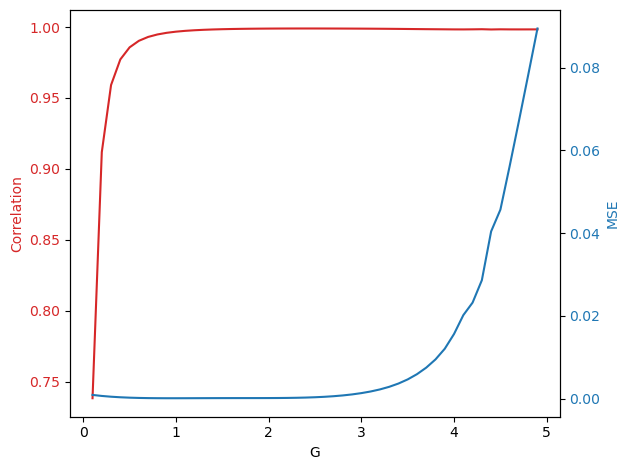

In [11]:
#Do a shared y-axis plot where in the left axis you show the correlation and in the right axis you show the MSE
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('G')
ax1.set_ylabel('Correlation', color=color)
ax1.plot(G_values, corr_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('MSE', color=color)  # we already handled the x-label with ax1
ax2.plot(G_values, mse_values, color=color)
ax2.tick_params(axis='y', labelcolor=color)
# add legend to distinguish between the two lines

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


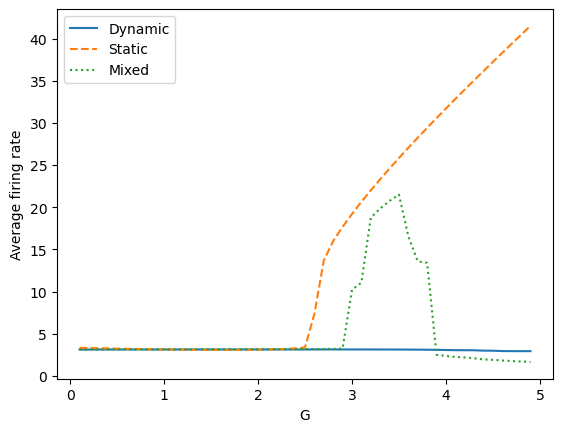

In [16]:
# plot thes average firing rates for the dynamic and static simulations
plt.figure()
plt.plot(G_values, np.mean(avg_fr_dyn_values, axis=1))
plt.plot(G_values, np.mean(avg_fr_stat_values, axis=1), '--')
plt.plot(G_values, np.mean(avg_fr_mixed_values, axis=1), ':')
plt.xlabel('G')
plt.ylabel('Average firing rate')
plt.legend(['Dynamic', 'Static', 'Mixed'])
plt.show()



## Figure 1.b


In [40]:
import fastdyn_fic_dmf as dmf
from helper_functions import filter_bold
import numpy as np
from scipy.io import loadmat

C = loadmat('./data/SC_and_5ht2a_receptors.mat')['sc90']
coeffs = loadmat('./data/LinearFitCoefficients.mat')
a = coeffs['a'][0][0]
b = coeffs['b'][0][0]
C = 0.2 * C / np.max(C)
LR = 130
DECAY = np.exp(a + np.log(LR) * b)

def simulate(G_val):
    params = dmf.default_params(C=C)
    params['seed'] = 1
    params['TR'] = 2.4
    params['G'] = G_val
    params['lrj'] = LR
    params['taoj'] = DECAY
    params['J'] = 0.75 * params['G'] * params['C'].sum(axis=0).squeeze() + 1
    params['flp'] = 0.01
    params['fhp'] = 0.1
    nb_steps = 100000
    params['with_plasticity'] = True
    params['with_decay'] = True
    params['return_bold'] = True
    params['return_rate'] = True
    params['return_fic'] = True
    rates, rates_inh, bold, fic_t = dmf.run(params, nb_steps)
    return rates, rates_inh, bold, fic_t

# Define the G_val values
G_vals = [1.5,3.5 6, 8.5]

# Collect the return values for each G_val
results = {}
for G_val in G_vals:
    results[G_val] = simulate(G_val)

# Access the results using the G_val values
# Create arrays to store the results
burnout = 10000
rates_results = np.zeros((len(G_vals), 90, nb_steps - burnout))
rates_inh_results = np.zeros((len(G_vals), 90, nb_steps - burnout))
bold_results = np.zeros((len(G_vals), 90, nb_steps  - burnout))
fic_t_results = np.zeros((len(G_vals), 90, nb_steps - burnout))
# Iterate over the G_vals and store the results

for G_val, result in results.items():
    rates, rates_inh, _, fic_t = result
    rates_results[G_vals.index(G_val)] = rates[:, burnout:]
    rates_inh_results[G_vals.index(G_val)] = rates_inh[:, burnout:]
    fic_t_results[G_vals.index(G_val)] = fic_t[:, burnout:]

   

In [45]:
# Save the results in ~/Desktop/DatosParaRuben/ChequeoPreliminar as separate .npy files
data_path = "~/Desktop/DatosParaRuben/ChequeoPreliminar"
np.save("/home/ivan.mindlin/Desktop/DatosParaRuben/slow_waves/time_series_examples/rates_results.npy", rates_results)
np.save("/home/ivan.mindlin/Desktop/DatosParaRuben/slow_waves/time_series_examples/rates_inh_results.npy", rates_inh_results)
np.save("/home/ivan.mindlin/Desktop/DatosParaRuben/slow_waves/time_series_examples/fic_t_results.npy", fic_t_results)
np.save("/home/ivan.mindlin/Desktop/DatosParaRuben/slow_waves/time_series_examples/G_vals.npy", G_vals)


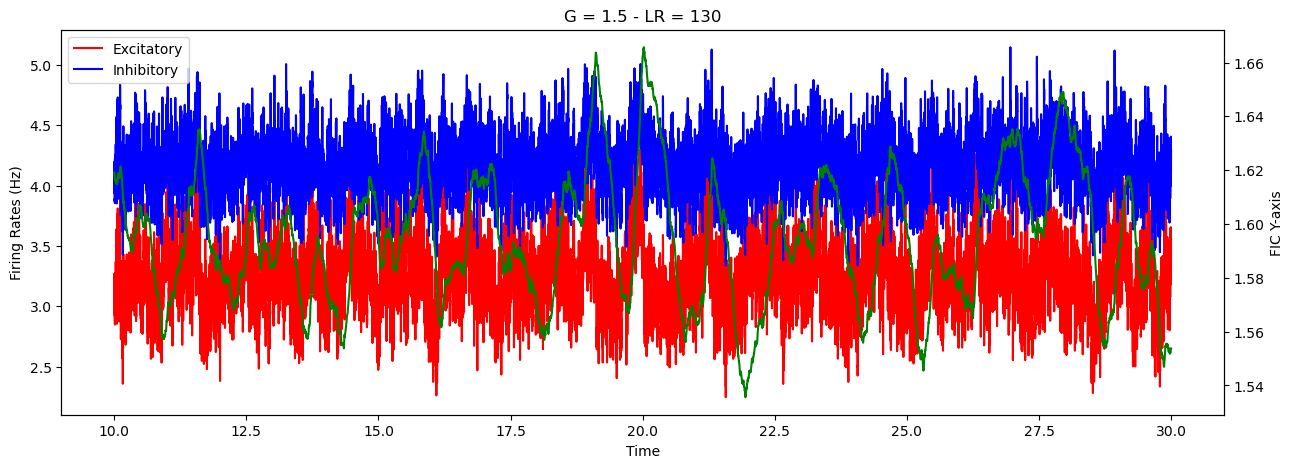

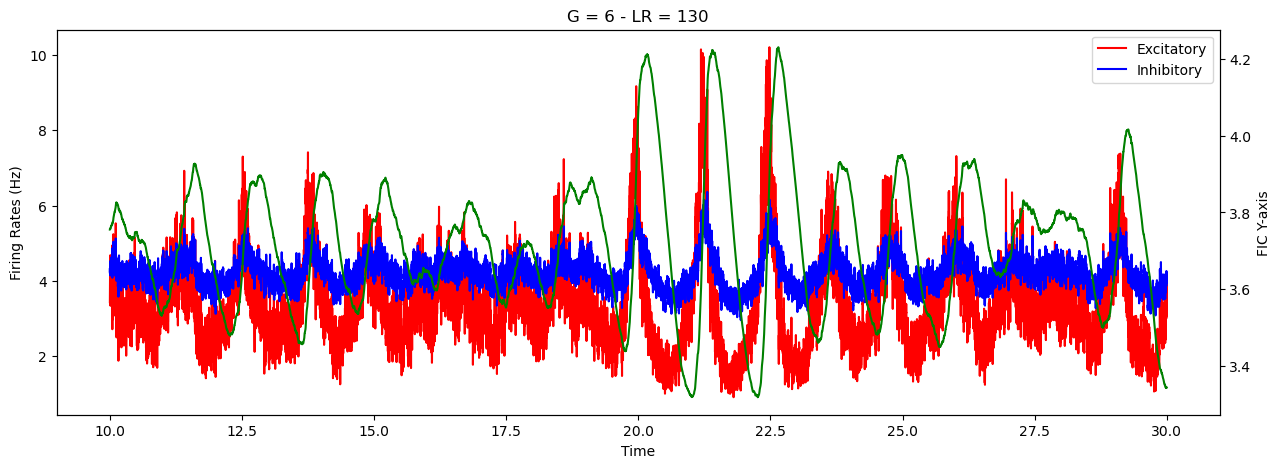

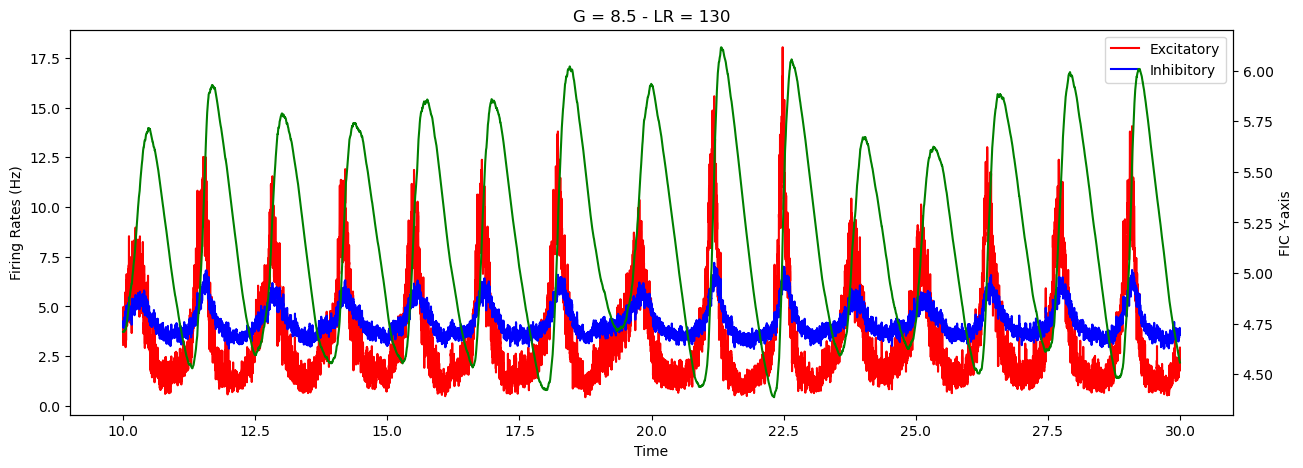

In [46]:
for i in range(len(G_vals)):
    # Make a wide figure
    plt.figure(figsize=(15, 5))
    
    sel_t = np.arange(10000, 30000) #np.arange(1,rates_results.shape[1] +1 ) 
    plt.plot(sel_t / 1000, np.mean(rates_results[i][:,sel_t-1],axis=0), 'r')
    plt.plot(sel_t / 1000, np.mean(rates_inh_results[i][:,sel_t-1],axis=0), 'b')
    plt.xlabel('Time')
    plt.ylabel('Firing Rates (Hz)')
    # add legend to distinguish between the two lines
    plt.legend(['Excitatory', 'Inhibitory'])
    plt.twinx()
    plt.plot(sel_t / 1000, np.mean(fic_t_results[i][:,sel_t-1], axis=0), color=[0, 0.5, 0])
    plt.ylabel('FIC Y-axis')
    plt.title(f'G = {G_vals[i]} - LR = {LR}')

In [23]:
from scipy.signal import find_peaks
def get_peak_and_ms(rates):
    """Get the value of the first peak from the autocorrealtion of the average firing rates"""
    signal = np.mean(rates, axis=0)
    signal -= np.mean(signal)

    # Calculate autocorrelation function
    autocorr = np.correlate(signal, signal, mode='full')

    # Normalize the autocorrelation function
    autocorr = autocorr / np.var(signal) / len(signal)
    autocorr = autocorr[len(signal)-1:]
    peaks, _ = find_peaks(autocorr, height=(0.2,0.8), prominence=0.2)
    if peaks.size==0:
        autocorr_value = 0
        time = 0
    else:
        autocorr_value = autocorr[peaks[0]]
        time = peaks[0]
    return autocorr_value,time, autocorr


In [24]:
auto_val, auto_time, autocorr = get_peak_and_ms(rates)

In [ ]:
hom_grid = np.load('./Results/Figure1/HomeostaticFit3-44-Grid/mean_hom_fit_grid.npy')
LR_range = np.logspace(0,3,100)
DECAY_range = np.logspace(2,6,110)
normalized_hom_grid = (hom_grid-np.nanmean(hom_grid))
fig, ax = plt.subplots()
pos = ax.imshow(normalized_hom_grid.T, cmap='seismic', vmin=-3, vmax=3)
xtick_positions = range(0, len(DECAY_range), 20)
ax.set_xticks(xtick_positions)
ax.set_xticklabels([f"{int(DECAY_range[i])}" for i in xtick_positions])
ax.set_xlabel("DECAY")
ytick_positions = range(0, len(LR_range), 10)
ax.invert_yaxis()
ax.set_yticks(ytick_positions)
ax.set_yticklabels([f"{int(LR_range[i])}" for i in ytick_positions])
ax.set_ylabel("LR")

fig.colorbar(pos, ax=ax)
plt.title("homeostatic fittness")


In [ ]:
fig, axs = plt.subplots(1,4, figsize=(20,10))

hom_grid = np.load('./Results/Figure1/HomeostaticFit1-22-Grid/mean_hom_fit_grid.npy')
LR_range = np.logspace(0,3,100)
DECAY_range = np.logspace(2,6,110)
#hom_grid = (hom_grid-np.nanmean(hom_grid))
pos = axs[0].imshow(hom_grid.T, cmap='seismic', vmin=-3, vmax=3)
xtick_positions = range(0, len(DECAY_range), 20)
axs[0].set_xticks(xtick_positions)
axs[0].set_xticklabels([f"{int(DECAY_range[i])}" for i in xtick_positions])
axs[0].set_xlabel("DECAY")
ytick_positions = range(0, len(LR_range), 10)
axs[0].invert_yaxis()
axs[0].set_yticks(ytick_positions)
axs[0].set_yticklabels([f"{int(LR_range[i])}" for i in ytick_positions])
axs[0].set_ylabel("LR")
#fig.colorbar(pos, ax=axs[0])
axs[0].set_title("homeostatic fittness 1-22")


hom_grid = np.load('./Results/Figure1/HomeostaticFit3-44-Grid/mean_hom_fit_grid.npy')
LR_range = np.logspace(0,3,100)
DECAY_range = np.logspace(2,6,110)
#hom_grid = (hom_grid-np.nanmean(hom_grid))
pos = axs[1].imshow(hom_grid.T, cmap='seismic', vmin=-3, vmax=3)
xtick_positions = range(0, len(DECAY_range), 20)
axs[1].set_xticks(xtick_positions)
axs[1].set_xticklabels([f"{int(DECAY_range[i])}" for i in xtick_positions])
axs[1].set_xlabel("DECAY")
ytick_positions = range(0, len(LR_range), 10)
axs[1].invert_yaxis()
axs[1].set_yticks(ytick_positions)
axs[1].set_yticklabels([f"{int(LR_range[i])}" for i in ytick_positions])
axs[1].set_ylabel("LR")
#fig.colorbar(pos, ax=axs[1])
axs[1].set_title("homeostatic fittness 3-44")

hom_grid = np.load('./Results/Figure1/HomeostaticFit6-88-Grid/mean_hom_fit_grid.npy')
LR_range = np.logspace(0,3,100)
DECAY_range = np.logspace(2,6,110)
#hom_grid = (hom_grid-np.nanmean(hom_grid))
pos = axs[2].imshow(hom_grid.T, cmap='seismic', vmin=-3, vmax=3)
xtick_positions = range(0, len(DECAY_range), 20)
axs[2].set_xticks(xtick_positions)
axs[2].set_xticklabels([f"{int(DECAY_range[i])}" for i in xtick_positions])
axs[2].set_xlabel("DECAY")
ytick_positions = range(0, len(LR_range), 10)
axs[2].invert_yaxis()
axs[2].set_yticks(ytick_positions)
axs[2].set_yticklabels([f"{int(LR_range[i])}" for i in ytick_positions])
axs[2].set_ylabel("LR")
#fig.colorbar(pos, ax=axs[2])
axs[2].set_title("homeostatic fittness 6-88")

hom_grid = np.load('./Results/Figure1/HomeostaticFit50-Grid/mean_hom_fit_grid.npy')
LR_range = np.logspace(0,3,100)
DECAY_range = np.logspace(2,6,110)
#hom_grid = (hom_grid-np.nanmean(hom_grid))
pos = axs[3].imshow(hom_grid.T, cmap='seismic', vmin=-3, vmax=3)
xtick_positions = range(0, len(DECAY_range), 20)
axs[3].set_xticks(xtick_positions)
axs[3].set_xticklabels([f"{int(DECAY_range[i])}" for i in xtick_positions])
axs[3].set_xlabel("DECAY")
ytick_positions = range(0, len(LR_range), 10)
axs[3].invert_yaxis()
axs[3].set_yticks(ytick_positions)
axs[3].set_yticklabels([f"{int(LR_range[i])}" for i in ytick_positions])
axs[3].set_ylabel("LR")
fig.colorbar(pos, ax=axs[3])
axs[3].set_title("homeostatic fittness 50")
plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(1,4, figsize=(20,10))

hom_grid = np.load('./Results/Figure1/HomeostaticFit1-22-Grid/std_hom_fit_grid.npy')
LR_range = np.logspace(0,3,100)
DECAY_range = np.logspace(2,6,110)
#hom_grid = (hom_grid-np.nanmean(hom_grid))
pos = axs[0].imshow(hom_grid.T, cmap='viridis', vmin=0, vmax=3)
xtick_positions = range(0, len(DECAY_range), 20)
axs[0].set_xticks(xtick_positions)
axs[0].set_xticklabels([f"{int(DECAY_range[i])}" for i in xtick_positions])
axs[0].set_xlabel("DECAY")
ytick_positions = range(0, len(LR_range), 10)
axs[0].invert_yaxis()
axs[0].set_yticks(ytick_positions)
axs[0].set_yticklabels([f"{int(LR_range[i])}" for i in ytick_positions])
axs[0].set_ylabel("LR")
#fig.colorbar(pos, ax=axs[0])
axs[0].set_title("homeostatic fittness 1-22")


hom_grid = np.load('./Results/Figure1/HomeostaticFit3-44-Grid/std_hom_fit_grid.npy')
LR_range = np.logspace(0,3,100)
DECAY_range = np.logspace(2,6,110)
#hom_grid = (hom_grid-np.nanmean(hom_grid))
pos = axs[1].imshow(hom_grid.T, cmap='viridis', vmin=0, vmax=3)
xtick_positions = range(0, len(DECAY_range), 20)
axs[1].set_xticks(xtick_positions)
axs[1].set_xticklabels([f"{int(DECAY_range[i])}" for i in xtick_positions])
axs[1].set_xlabel("DECAY")
ytick_positions = range(0, len(LR_range), 10)
axs[1].invert_yaxis()
axs[1].set_yticks(ytick_positions)
axs[1].set_yticklabels([f"{int(LR_range[i])}" for i in ytick_positions])
axs[1].set_ylabel("LR")
#fig.colorbar(pos, ax=axs[1])
axs[1].set_title("homeostatic fittness 3-44")

hom_grid = np.load('./Results/Figure1/HomeostaticFit6-88-Grid/std_hom_fit_grid.npy')
LR_range = np.logspace(0,3,100)
DECAY_range = np.logspace(2,6,110)
#hom_grid = (hom_grid-np.nanmean(hom_grid))
pos = axs[2].imshow(hom_grid.T, cmap='viridis', vmin=0, vmax=3)
xtick_positions = range(0, len(DECAY_range), 20)
axs[2].set_xticks(xtick_positions)
axs[2].set_xticklabels([f"{int(DECAY_range[i])}" for i in xtick_positions])
axs[2].set_xlabel("DECAY")
ytick_positions = range(0, len(LR_range), 10)
axs[2].invert_yaxis()
axs[2].set_yticks(ytick_positions)
axs[2].set_yticklabels([f"{int(LR_range[i])}" for i in ytick_positions])
axs[2].set_ylabel("LR")
#fig.colorbar(pos, ax=axs[2])
axs[2].set_title("homeostatic fittness 6-88")

hom_grid = np.load('./Results/Figure1/HomeostaticFit50-Grid/std_hom_fit_grid.npy')
LR_range = np.logspace(0,3,100)
DECAY_range = np.logspace(2,6,110)
#hom_grid = (hom_grid-np.nanmean(hom_grid))
pos = axs[3].imshow(hom_grid.T, cmap='viridis', vmin=0, vmax=3)
xtick_positions = range(0, len(DECAY_range), 20)
axs[3].set_xticks(xtick_positions)
axs[3].set_xticklabels([f"{int(DECAY_range[i])}" for i in xtick_positions])
axs[3].set_xlabel("DECAY")
ytick_positions = range(0, len(LR_range), 10)
axs[3].invert_yaxis()
axs[3].set_yticks(ytick_positions)
axs[3].set_yticklabels([f"{int(LR_range[i])}" for i in ytick_positions])
axs[3].set_ylabel("LR")
fig.colorbar(pos, ax=axs[3])
axs[3].set_title("homeostatic fittness 50")
plt.tight_layout()

In [3]:

burnout = 5
flp = 0.01
fhp = 0.1
b_filter,a_filter = butter(2,np.array([flp, fhp])*2*params['TR'], btype='band')
wsize = 30
overlap = 29
T = 192 - burnout
win_start = np.arange(0, T - wsize - 1, wsize - overlap)
nwins = len(win_start)
isubfc = np.triu_indices(C.shape[1],1)
nints = len(isubfc[0])
isubfcd = np.triu_indices(nwins,1)
NSUB = 13
emp_fcds = np.zeros((NSUB,nwins,nwins))
emp_fcs = np.zeros((NSUB,params['N'],params['N']))
for i in range(NSUB):
    bold = data[i]
    bold = bold[:, burnout:]    
    #filt_bold = lfilter(b_filter,a_filter,bold)
    filt_bold = bold
    time_fc = compute_fcd(filt_bold.T, wsize, overlap, isubfc)    
    bold_fc = np.corrcoef(filt_bold)
    fcd = np.corrcoef(time_fc.T)       
    emp_fcds[i] = fcd
    emp_fcs[i] = bold_fc

coeffs = loadmat('./data/LinearFitCoefficients.mat')
a = coeffs['a'][0][0]
b = coeffs['b'][0][0]
params['N'] = C.shape[0]
params['TR'] = 2.4
nb_steps = int((data.shape[-1]-burnout)*params['TR']/params['dtt'])


# Define the number of cores to use
NUM_CORES = NSUB+1

def parallelized_function(rep, params, nb_steps, burnout, TR, b_filter, a_filter, wsize, overlap, isubfc):
    rates, _, bold, _ = dmf.run(params, nb_steps)         
    filt_bold = lfilter(b_filter, a_filter, bold)
    filt_bold = bold
    time_fc = compute_fcd(filt_bold.T, wsize, overlap, isubfc)
    bold_fc = np.corrcoef(filt_bold)
    fcd = np.corrcoef(time_fc.T)
    mean_rates = np.mean(rates, axis=1)
    return bold_fc, fcd,mean_rates

def run_parallel(NSUB, params, nb_steps, burnout, TR, b_filter, a_filter, wsize, overlap, isubfc):
    sim_fcs = Parallel(n_jobs=NSUB)(delayed(parallelized_function)(rep, params, nb_steps, burnout, TR, b_filter, a_filter, wsize, overlap, isubfc) for rep in range(NSUB))
    return sim_fcs


def dmf_step_dyn(args):
    sim_fcds = np.zeros((NSUB,nwins,nwins))
    sim_fcs = np.zeros((NSUB,params['N'],params['N']))
    sim_rates = np.zeros((NSUB, params['N']))
    G, LR = args    
    print(f"Doing {G} {LR}")
    DECAY = np.exp(a+np.log(LR)*b)
    OBJ_RATE = 3.44    
    params['lrj'] = LR
    params['G'] = G
    # Using heuristic linear rule 
    params['taoj'] = DECAY 
    params['obj_rate'] = OBJ_RATE    
    params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
    params['with_decay'] = False
    params['with_plasticity]'] = False
    params['seed']=RANDOM_STATE
    parallel_results = run_parallel(NSUB, params, nb_steps, burnout, params['TR'], b_filter, a_filter, wsize, overlap, isubfc)
    for rep in range(len(parallel_results)):
        sim_fcs[rep,:,:] = parallel_results[rep][0]
        sim_fcds[rep,:,:] = parallel_results[rep][1]
        sim_rates[rep,:] = parallel_results[rep][2]
    
    crashed = np.isnan(np.mean(sim_fcs,axis=0)).any()
    mean_fc = np.mean(sim_fcs,axis=0) if not crashed else np.zeros((params['N'],params['N']))        

    corr_to_sc = 0 if crashed else pearsonr(mean_fc[isubfc[0],isubfc[1]], np.mean(emp_fcs,axis=0)[isubfc[0],isubfc[1]])[0]              
    
    ks, p = 1, 1 if crashed else ks_2samp(sim_fcds[:,isubfcd[0],isubfcd[1]].flatten(),emp_fcds[:,isubfcd[0],isubfcd[1]].flatten())        
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)    
    filename = f"mean-fc.txt"    
    file_path = os.path.join(folder_path, filename)    
    np.savetxt(file_path, mean_fc)
    
    filename = f"ratestxt"    
    file_path = os.path.join(folder_path, filename)    
    np.savetxt(file_path, np.mean(sim_rates,axis=0))


    filename = f"corr-to-sc.txt"    
    file_path = os.path.join(folder_path, filename)    
    with open(file_path, 'w') as file:
        file.write(str(corr_to_sc))

    filename = f"ks.txt"    
    file_path = os.path.join(folder_path, filename)    
    with open(file_path, 'w') as file:
        file.write(str(ks))
    
    return 1-corr_to_sc



def intermediate_save(res):
    
    # Load mean-fc.txt
    filename_mean_fc = "mean-fc.txt"
    file_path_mean_fc = os.path.join(folder_path, filename_mean_fc)
    mean_fc = np.loadtxt(file_path_mean_fc)
    # Load corr-to-sc.txt
    filename_corr_to_sc = "corr-to-sc.txt"
    file_path_corr_to_sc = os.path.join(folder_path, filename_corr_to_sc)
    with open(file_path_corr_to_sc, 'r') as file:
        corr_to_sc = float(file.read())
    
    file_path = os.path.join(folder_path, "best_result.txt")

    # Check if the file exists
    if os.path.exists(file_path):
        # If the file exists, load the previous best result
        with open(file_path, 'r') as file:
            best_result = float(file.read())

        # Compare with the current result and update if necessary
        if res.fun < best_result:
            with open(file_path, 'w') as file:
                file.write(str(res.fun))
            iter_folder_path = os.path.join(folder_path, f"iter_{len(res.x_iters)}")
            if not os.path.exists(iter_folder_path):
               os.makedirs(iter_folder_path)   
            filename = f"mean-fc.txt"    
            file_path = os.path.join(iter_folder_path, filename)    
            np.savetxt(file_path, mean_fc)

            filename = f"corr-to-sc.txt"    
            file_path = os.path.join(iter_folder_path, filename)    
            with open(file_path, 'w') as file:
                file.write(str(corr_to_sc))

            filename = f"res.pkl"    
            file_path = os.path.join(iter_folder_path, filename)    
            with open(file_path, 'wb') as file:
                pkl.dump(res,file)

    else:
        # If the file doesn't exist, create it and save the current result
        with open(file_path, 'w') as file:
            file.write(str(res.fun))
        iter_folder_path = os.path.join(folder_path, f"iter_{len(res.x_iters)}")
        if not os.path.exists(iter_folder_path):
            os.makedirs(iter_folder_path)   
        filename = f"mean-fc.txt"    
        file_path = os.path.join(iter_folder_path, filename)    
        np.savetxt(file_path, mean_fc)

        filename = f"corr-to-sc.txt"    
        file_path = os.path.join(iter_folder_path, filename)    
        with open(file_path, 'w') as file:
            file.write(str(corr_to_sc))

        filename = f"res.pkl"    
        file_path = os.path.join(iter_folder_path, filename)    
        with open(file_path, 'wb') as file:
            pkl.dump(res,file)



G_range = (0.0, 8.0)
LR_range = (1.0,1000.0)

dmf_step_dyn((2.1, 100))

Doing 2.1 100


0.7412353168370636

In [72]:
import fastdyn_fic_dmf as dmf
from helper_functions import filter_bold

C = loadmat('./data/SC_and_5ht2a_receptors.mat')['sc90']
C = 0.2*C/np.max(C)
params = dmf.default_params(C=C)
params['seed'] = 1
params['TR'] = 2.4
params['G'] = 2.1
params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
params['flp'] = 0.01
params['fhp'] = 0.1
nb_steps = 448800
params['with_plasticity'] = False
params['with_decay'] = False
params['return_bold'] = True
params['return_rate'] = False
params['return_fic'] = True
burnout=8
rates, rates_inh, bold, fic_t = dmf.run(params, nb_steps)    
bold = bold[:,burnout-1:]
filt_bold = filter_bold(bold.T, params['flp'],params['fhp'], params['TR'])
filt_bold = filt_bold.T

In [24]:
192*2.4*1000

460799.99999999994

In [5]:
import os
import numpy as np
arrays_to_save = ['fcs_grid',
    'fcds_grid',
    'bold_grid']

results_folder = "./Results/FittedSimulations"
results = {}
for array_name in arrays_to_save:
    file_name = os.path.join(results_folder, f"{array_name}.npy")
    results[array_name] = np.load(file_name)